In [38]:
import sionna
from sionna.rt import load_scene, RadioMapSolver, Transmitter, PlanarArray, Scene, \
                      DEFAULT_FREQUENCY, DEFAULT_BANDWIDTH, DEFAULT_TEMPERATURE
import numpy as np
import matplotlib.pyplot as plt

from scipy.constants import c

from tqdm import tqdm

from scipy.signal import correlate
from scipy.ndimage import uniform_filter1d
from scipy.stats import rayleigh, rice

In [32]:
lambda_ = c / DEFAULT_FREQUENCY
step_size = lambda_ / 20
positions = np.arange(1, 2, step_size)

dx = dy = lambda_ / 10.0
GRID_N = 512
SIZE_X = GRID_N * dx
SIZE_Y = GRID_N * dy

In [45]:
def path_gain_loss_test(scene, positions: np.ndarray) -> np.ndarray:
    scene.tx_array = PlanarArray(num_rows=1, num_cols=1, polarization='V', pattern='iso')
    scene.remove('tx1'); scene.remove('tx2')
    tx1 = Transmitter('tx1', position=[0.0, 0.0, 10.0])
    scene.add(tx1)

    results = np.zeros((len(positions), GRID_N, GRID_N), dtype=float)
    rm_solver = RadioMapSolver()

    for i, pos in tqdm(enumerate(positions), total=len(positions)):
        scene.remove('tx2')
        tx2 = Transmitter('tx2', position=[-float(pos), 0.0, 10.0])
        scene.add(tx2)

        rm = rm_solver(
            scene,
            max_depth=5,
            samples_per_tx=10**6,
            cell_size=(dx, dy),
            center=(0.0, 0.0, 0.0),
            size=(SIZE_X, SIZE_Y),
            orientation=(0.0, 0.0, 0.0)
        )

        results[i] = np.max(rm.path_gain, axis=0)

    return results


def heatmap(z: np.ndarray) -> None:
    """Plot the path gain map using matplotlib."""
    plt.imshow(z, cmap='viridis', origin='lower')
    plt.colorbar(label='Path Gain (dB)')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Path Gain Map')
    plt.show()


# DOES NOT WORK FOR JUPYTER NOTEBOOKS
def plot_movie(ndarray: np.ndarray) -> None:
    # --- after you compute res (T, Ny, Nx) and know size/center ---
    SIZE_X, SIZE_Y = SIZE_X, SIZE_Y         # same as in RadioMapSolver
    CENTER_X, CENTER_Y = 0.0, 0.0           # same center as in solver
    extent = [CENTER_X - SIZE_X/2, CENTER_X + SIZE_X/2,
            CENTER_Y - SIZE_Y/2, CENTER_Y + SIZE_Y/2]

    plt.ion()
    fig, ax = plt.subplots(1, figsize=(8, 7))

    rmin, rmax = np.nanmin(ndarray), np.nanmax(ndarray)
    im0 = ax.imshow(ndarray[0], cmap='viridis', origin='lower',
                    vmin=rmin, vmax=rmax, extent=extent)

    # initial TX positions in world coords
    tx1_xy = np.array([0.0, 0.0])                  # fixed
    tx2_xy = np.array([-float(positions[0]), 0.0]) # moving

    tx1_sc = ax.scatter([tx1_xy[0]], [tx1_xy[1]], c='red', s=80, label='TX1')
    tx2_sc = ax.scatter([tx2_xy[0]], [tx2_xy[1]], c='blue', s=80, label='TX2')
    ax.legend()

    ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)')
    cbar = fig.colorbar(im0, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Path Gain')
    fig.tight_layout()

    for i in range(len(positions)):
        # update heatmap
        im0.set_data(ndarray[i])

        # update TX2 position
        tx2_xy = np.array([-float(positions[i]), 0.0])
        tx2_sc.set_offsets(tx2_xy[None, :])   # expects shape (N,2)

        # (if TX1 moved, also call tx1_sc.set_offsets(...))

        # optional: title with center cell value
        pg_center = ndarray[i][ndarray[i].shape[0]//2, ndarray[i].shape[1]//2]
        ax.set_title(f'Path Gain (center): {pg_center:.2e}')

        fig.canvas.draw_idle()
        plt.pause(0.1)

    plt.ioff()
    plt.show()

In [41]:
IS_DB = True  # set False if res is linear

def map_mad(A, B):
    D = np.abs(A - B)
    D[np.isnan(A) | np.isnan(B)] = np.nan
    return float(np.nanmean(D))

def mad_vs_displacement(res, positions):
    mads = [map_mad(res[i], res[i+1]) for i in range(len(res)-1)]
    dx   = np.abs(np.diff(positions))
    return np.asarray(dx), np.asarray(mads)

def mad_vs_displacement_full(res, positions, max_step=50):
    """Compute mean absolute difference vs TX separation (k * ΔTX)."""
    T = len(res)
    dx = np.abs(np.diff(positions))
    delta = np.median(dx)
    ks, mad_vals = [], []

    for k in range(1, min(max_step, T)):
        diffs = []
        for i in range(T - k):
            diffs.append(map_mad(res[i], res[i+k]))
        ks.append(k)
        mad_vals.append(np.nanmean(diffs))

    return np.array(ks)*delta, np.array(mad_vals)


def centerline_series(res):
    T, H, W = res.shape
    j = H // 2
    band = res[:, max(0, j-2):min(H, j+3), :]
    return np.nanmean(band, axis=(1,2))  # (T,)

def detrend_small_scale(series_db_or_lin, win=11):
    """Return linear envelope amplitude with large-scale trend removed."""
    s = np.asarray(series_db_or_lin)
    if IS_DB:
        p_lin = 10**(s/10)  # power
    else:
        p_lin = np.clip(s, 0, None)  # already linear power
    trend = uniform_filter1d(p_lin, size=win, mode='nearest')
    small = p_lin / np.maximum(trend, 1e-30)   # normalized power
    amp   = np.sqrt(small)                      # envelope amplitude (linear)
    return amp

def spatial_autocorr(series):
    x = np.asarray(series)
    x = x[~np.isnan(x)]
    x = x - np.mean(x)
    if len(x) < 3: return np.array([1.0])
    c = correlate(x, x, mode='full')
    c = c[c.size//2:]
    return c / (c[0] + 1e-30)

def plot_small_scale_suite(res, positions, lambda_):
    # 1) MAD vs displacement (ΔTX)
    dx, mads = mad_vs_displacement_full(res, positions)
    plt.figure(figsize=(7,3))
    plt.plot(dx, mads, 'o-')
    plt.axvline(lambda_/2, color='r', ls='--', label='~ λ/2')
    plt.xlabel('ΔTX (m)')
    plt.ylabel('MAD (dB)' if IS_DB else 'MAD (linear)')
    plt.title('MAD between consecutive maps')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2) Envelope along path (detrended) & autocorr
    s = centerline_series(res)
    amp = detrend_small_scale(s, win=max(5, len(s)//20))
    d = np.abs(positions - positions[0])

    plt.figure(figsize=(7,3))
    plt.plot(d, 20*np.log10(amp+1e-12) if IS_DB else amp, '-')
    plt.xlabel('TX displacement (m)')
    plt.ylabel('Normalized envelope (dB)' if IS_DB else 'Normalized envelope')
    plt.title('Normalized small-scale envelope along TX path')
    plt.tight_layout()
    plt.show()

    R = spatial_autocorr(amp)
    dd = np.arange(len(R)) * (np.median(np.diff(d)) if len(d) > 1 else 0.0)
    plt.figure(figsize=(7,3))
    plt.plot(dd, R, '-')
    plt.axvline(lambda_/2, color='r', ls='--', label='~ λ/2')
    plt.xlabel('Lag distance (m)'); plt.ylabel('Autocorrelation')
    plt.title('Spatial autocorrelation of envelope')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3) Envelope histogram vs Rayleigh / Rician (linear amplitude)
    amp = np.clip(amp, 0, None)
    rms = np.sqrt(np.mean(amp**2)) + 1e-12
    a = amp / rms                             # unit-RMS amplitude
    sigma = 1/np.sqrt(2)                      # Rayleigh with RMS=1

    xmax = max(3.0, np.percentile(a, 99.5))
    xs = np.linspace(0, xmax, 400)
    bins = np.linspace(0, xmax, 50)

    plt.figure(figsize=(7,3))
    plt.hist(a, bins=bins, density=True, alpha=0.5, label='Measured')
    plt.plot(xs, rayleigh.pdf(xs, scale=sigma), 'r--', label='Rayleigh (RMS=1)')

    try:
        b_hat, _, scale_hat = rice.fit(a, floc=0)  # simple fit
        plt.plot(xs, rice.pdf(xs, b_hat, loc=0, scale=scale_hat),
                 'g--', label=f'Rician fit (b={b_hat:.2f}, sc={scale_hat:.2f})')
    except Exception:
        pass

    plt.xlabel('Normalized amplitude (linear)')
    plt.ylabel('PDF')
    plt.title('Envelope statistics')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [42]:
res_empty_scene = path_gain_loss_test(load_scene(), positions)

100%|██████████| 234/234 [00:06<00:00, 34.97it/s]


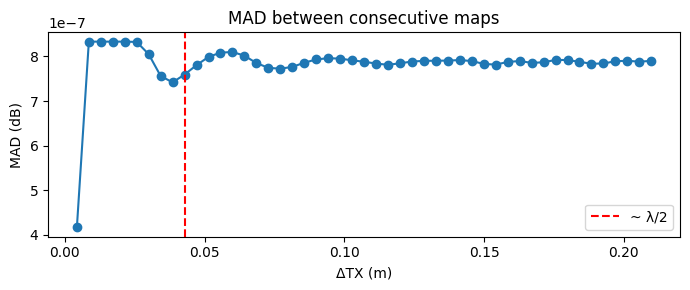

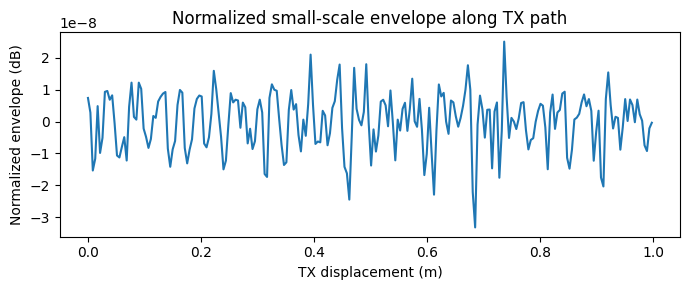

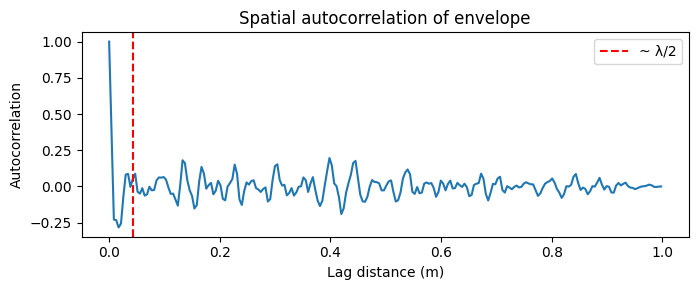

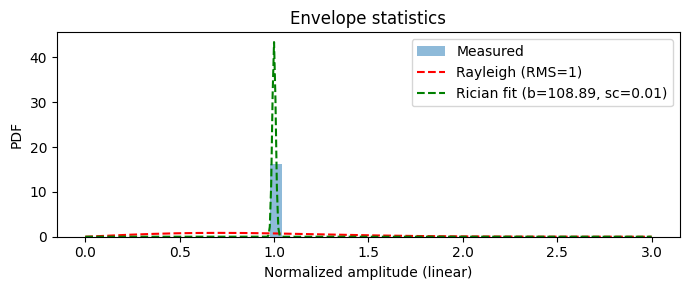

In [43]:
plot_small_scale_suite(res_empty_scene, positions, lambda_)

In [39]:
res_simple_street_canyon = path_gain_loss_test(load_scene(sionna.rt.scene.simple_street_canyon), positions)

100%|██████████| 234/234 [00:24<00:00,  9.46it/s]


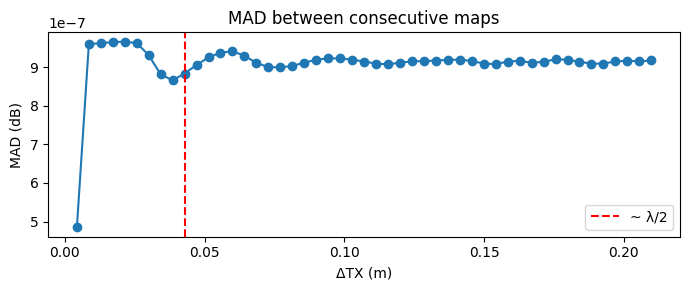

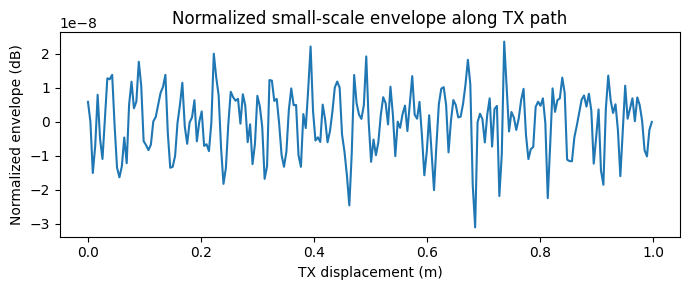

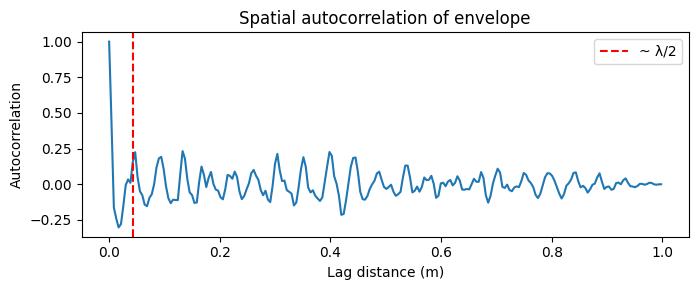

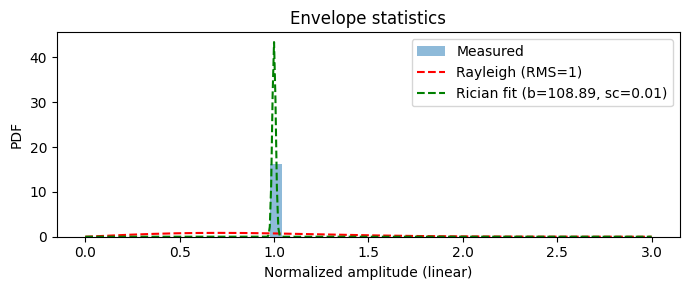

In [44]:
plot_small_scale_suite(res_simple_street_canyon, positions, lambda_)

TODO: Test for different scenes with more multipath/ scattering components